In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)


!python -m pip install traitlets==4.3.3 --force-reinstall
!pip install pywin32==228

print(torch.cuda.is_available())



2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: ipython-genutils
    Found existing installation: ipython-genutils 0.2.0
    Uninstalling ipython-genutils-0.2.0:
      Successfully uninstalled ipython-genutils-0.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.1

## Importing Training Text (can be changed later on)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/LLM TESTING/NanoGPT/data/don_quixote.txt', "r", encoding = 'utf-8') as f:
    text = f.read()

text= text.replace('\n', ' ').replace('  ', ' ')[121506:]
text[:1000]

Mounted at /content/drive


'sed by many more; for if you succeed in this you will have achieved no small success.” In profound silence I listened to what my friend said, and his observations made such an impression on me that, without attempting to question them, I admitted their soundness, and out of them I determined to make this Preface; wherein, gentle reader, thou wilt perceive my friend’s good sense, my good fortune in finding such an adviser in such a time of need, and what thou hast gained in receiving, without addition or alteration, the story of the famous Don Quixote of La Mancha, who is held by all the inhabitants of the district of the Campo de Montiel to have been the chastest lover and the bravest knight that has for many years been seen in that neighbourhood. I have no desire to magnify the service I render thee in making thee acquainted with so renowned and honoured a knight, but I do desire thy thanks for the acquaintance thou wilt make with the famous Sancho Panza, his squire, in whom, to my t

In [3]:
print('Words on .txt file: ', len(text))

chars = sorted(list(set(text)))
char_vocab_size = len(chars)

print('Unique characters: ', char_vocab_size)
print(''.join(chars))
print()

Words on .txt file:  2190617
Unique characters:  100
 !$%&()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyzÁÆÑÚàáæéëíñóùŒœ—‘’“”•™



## Using TikToken For Tokenization (can be changed later on to other like SentencePiece)
Tiktoken does tokenization per word and special character.

In [4]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [5]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

In [6]:
#Testing encoder
encoded_test_str= enc.encode('testing')
print("Tonkenized 'testing': ", encoded_test_str)

decoded_test_str= enc.decode(encoded_test_str)
print(decoded_test_str)

Tonkenized 'testing':  [33407]
testing


## Preparing Training Data

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

encoded_text = enc.encode(text)
data = torch.tensor(encoded_text, dtype=torch.long)

print('Encoded text: ', encoded_text[:100])
print('Decoded text: ', enc.decode(encoded_text[:100]))
print(data.shape)

Encoded text:  [36622, 416, 867, 517, 26, 329, 611, 345, 6758, 287, 428, 345, 481, 423, 8793, 645, 1402, 1943, 13, 447, 251, 554, 11982, 9550, 314, 16399, 284, 644, 616, 1545, 531, 11, 290, 465, 13050, 925, 884, 281, 10647, 319, 502, 326, 11, 1231, 9361, 284, 1808, 606, 11, 314, 6848, 511, 2128, 1108, 11, 290, 503, 286, 606, 314, 5295, 284, 787, 428, 3771, 2550, 26, 22881, 11, 10296, 9173, 11, 14210, 266, 2326, 19973, 616, 1545, 447, 247, 82, 922, 2565, 11, 616, 922, 15807, 287, 4917, 884, 281, 12534, 287, 884, 257, 640, 286, 761, 11, 290]
Decoded text:  sed by many more; for if you succeed in this you will have achieved no small success.” In profound silence I listened to what my friend said, and his observations made such an impression on me that, without attempting to question them, I admitted their soundness, and out of them I determined to make this Preface; wherein, gentle reader, thou wilt perceive my friend’s good sense, my good fortune in finding such an adviser in such a time

In [8]:
# Setting the training split to 90%
train_split = int(0.9 * len(data))
train_data = data[:train_split]
val_data = data[train_split:]

In [9]:
block_size = 128
x, y = train_data[0: block_size], train_data[1: block_size + 1]

for i in range(block_size):
    context= x[:i+1]
    target= y[i]
    print('Context: ', context, 'Target: ', target)

Context:  tensor([36622]) Target:  tensor(416)
Context:  tensor([36622,   416]) Target:  tensor(867)
Context:  tensor([36622,   416,   867]) Target:  tensor(517)
Context:  tensor([36622,   416,   867,   517]) Target:  tensor(26)
Context:  tensor([36622,   416,   867,   517,    26]) Target:  tensor(329)
Context:  tensor([36622,   416,   867,   517,    26,   329]) Target:  tensor(611)
Context:  tensor([36622,   416,   867,   517,    26,   329,   611]) Target:  tensor(345)
Context:  tensor([36622,   416,   867,   517,    26,   329,   611,   345]) Target:  tensor(6758)
Context:  tensor([36622,   416,   867,   517,    26,   329,   611,   345,  6758]) Target:  tensor(287)
Context:  tensor([36622,   416,   867,   517,    26,   329,   611,   345,  6758,   287]) Target:  tensor(428)
Context:  tensor([36622,   416,   867,   517,    26,   329,   611,   345,  6758,   287,
          428]) Target:  tensor(345)
Context:  tensor([36622,   416,   867,   517,    26,   329,   611,   345,  6758,   287,
  

In [10]:
def get_batch(data, seq_len, i):
    """Get a batch of data
    Parameters
    ----------
    data : torch.tensor
        The data to get the batch from
    seq_len : int
        The length of the sequence
    i : int
        The batch index
    Returns
    -------
    torch.tensor
        The input sequence
    torch.tensor
        The target sequence
    """
    seq_len = min(seq_len, len(data) - 1 - i)
    inputs = data[i: i + seq_len]
    targets = data[i + 1: i + 1 + seq_len].reshape(-1)
    return inputs, targets

def get_random_batch(split_type='train', block_size=8, batch_size = 4):
    """Get a random batch of data
    Parameters
    ----------
    split_type : str, optional
        The split to get the batch from, by default 'train'
    block_size : int, optional
        The size of the block (quantity of words per example in the batch), by default 8
    batch_size : int, optional
        The batch size (quantity of examples in the batch), by default 4
    Returns
    -------
    torch.tensor
        The input sequence of size (batch_size, block_size)
    torch.tensor
        The target sequence of size (batch_size, block_size)
    """
    data = train_data if split_type == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    x, y = x.to(device), y.to(device)

    return x, y



In [11]:
test_batch_x, test_batch_y= get_random_batch(split_type='train')
#printing the decoded batches
print('Batch input x: ', enc.decode(test_batch_x[0].tolist()))
print('Size of complete X Batch: ', test_batch_x.shape)
print('Batch target y: ', enc.decode(test_batch_y[0].tolist()))
print('Size of complete Y Batch: ', test_batch_y.shape)

vocab_size = len(encoded_text)

Batch input x:   everything in its own way, so ordered
Size of complete X Batch:  torch.Size([4, 8])
Batch target y:   in its own way, so ordered it
Size of complete Y Batch:  torch.Size([4, 8])


## Implementing Word2Vec Embeddings (can be changed later on like GloVe)
In this case, the embedding imported transforms each word and special character into a 300-dim vector, meaning that a sentence of 8 words will be transformed into a [8, 300] tensor.

In [12]:
#installing past numpy version
!pip install gensim
!pip install numpy==1.21.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jax 0.4.16 requires numpy>=1.22, but you have numpy 1.21.6 which is incompatible.
jaxlib 0.4.16+cuda11.cudnn86 requires numpy>=1.22, but you have numpy 1.21.6 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.
plotnine 0.12.3 requires numpy>=1.23.0, but you have numpy 1.21.6 which is incompatible.

In [13]:
#implementing word embedding using Word2Vec
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors

#loading model in './embedding_models/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/LLM TESTING/NanoGPT/embedding_models/GoogleNews-vectors-negative300.bin', binary=True)

In [14]:
#using the model to get embeddings of our text
embeddings = []
for word in text.split(' '):
    try:
        embeddings.append(model[word])
    except:
        pass

embeddings = np.array(embeddings)
print(embeddings.shape)

words_vocab_size = len(list(set( text.split(' '))))
print("Unique words (vocab size): ", words_vocab_size)

(298727, 300)
Unique words (vocab size):  31700


In [15]:
#printing an example of the embedding
print('Word: ', text.split(' ')[1])
print('Embedding: ', embeddings[1])

Word:  by
Embedding:  [-1.15722656e-01 -3.14941406e-02  1.59179688e-01  1.38671875e-01
 -5.06591797e-03  2.81982422e-02 -3.39355469e-02 -1.15722656e-01
  3.24707031e-02  1.38671875e-01 -1.00097656e-01 -1.26953125e-01
 -3.95507812e-02 -1.83105469e-02  2.34603882e-04 -8.05664062e-02
  4.51660156e-02  9.81445312e-02 -5.66406250e-02  6.00585938e-02
  8.88671875e-02  5.02929688e-02 -1.64794922e-02 -5.56640625e-02
  2.13867188e-01  1.42822266e-02 -1.31835938e-01  3.19824219e-02
  3.11279297e-02  1.25976562e-01 -3.47900391e-03 -1.55273438e-01
 -1.68945312e-01  1.40625000e-01  1.60156250e-01 -3.75976562e-02
 -9.47265625e-02 -3.90625000e-02  1.70898438e-01 -5.12695312e-02
  1.46484375e-01  9.61914062e-02 -2.66113281e-02  3.90625000e-02
  1.35742188e-01  5.27343750e-02 -4.15039062e-02 -5.20019531e-02
  1.57226562e-01  9.37500000e-02  5.67626953e-03  1.26953125e-01
 -5.31005859e-03 -4.80957031e-02  5.41992188e-02  1.66992188e-01
  3.85742188e-02  3.46679688e-02 -9.81445312e-02 -7.47070312e-02
 -1

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78c1a2f05b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so: cannot open shared object file: No such file or directory


Reducing dimensionality...
Done!


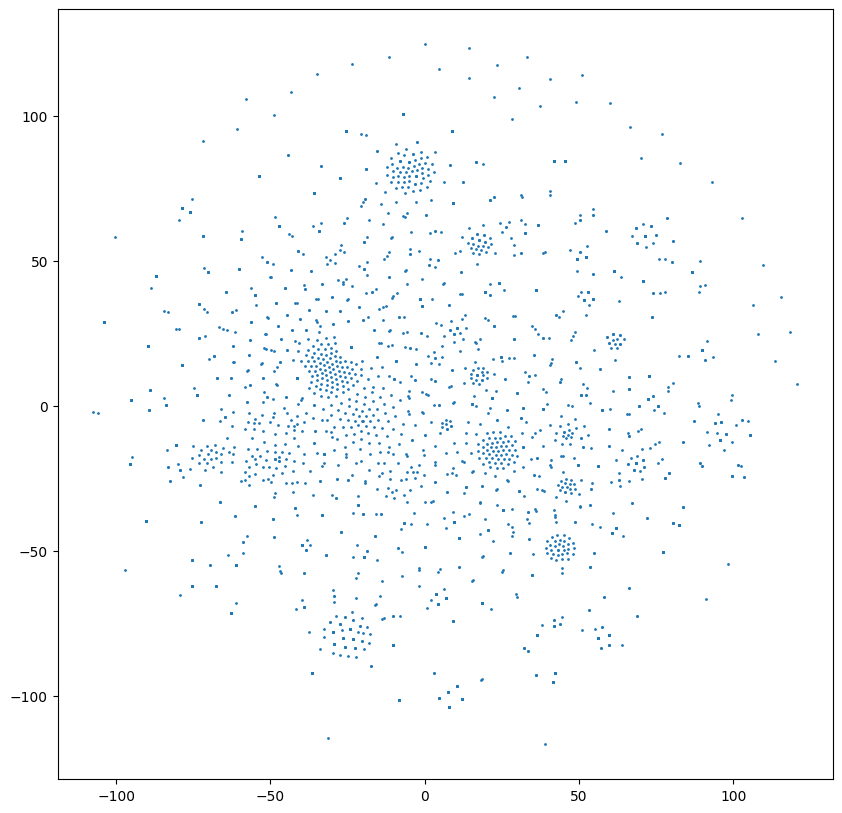

In [16]:
#using TSNE to reduce the dimensionality of the embeddings for just some words
print('Reducing dimensionality...')
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings[:2500])
print('Done!')

#plotting the embeddings using matplotlib
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)
plt.show()

## Making a Basic Bigram Model
Bigram models are the simplest form of language models that assigns probabilities to word sequences. It is based on the assumption that the probability of a word depends only on the previous word. In other words, it assumes that the probability of a word depends only on the previous word. The probability of a word depends on the previous two words in the case of a trigram model. The probability of a word depends on the previous n words in the case of an n-gram model.

This simple model is just a random model that generates the next character based on the last character (not even the last n-characters). *Tokens DO NOT talk to each other*.

In [17]:
# For now, we will be using a basic encoding using only individual characters

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("testing"))
print(decode(encode("testing")))

[71, 56, 70, 71, 60, 65, 58]
testing


In [18]:
# let's now encode the entire text dataset and *store it into a torch.Tensor*

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:500]) # the 500 characters we looked at earier will to the GPT look like this

torch.Size([2190617]) torch.int64
tensor([70, 56, 55,  0, 53, 76,  0, 64, 52, 65, 76,  0, 64, 66, 69, 56, 23,  0,
        57, 66, 69,  0, 60, 57,  0, 76, 66, 72,  0, 70, 72, 54, 54, 56, 56, 55,
         0, 60, 65,  0, 71, 59, 60, 70,  0, 76, 66, 72,  0, 74, 60, 63, 63,  0,
        59, 52, 73, 56,  0, 52, 54, 59, 60, 56, 73, 56, 55,  0, 65, 66,  0, 70,
        64, 52, 63, 63,  0, 70, 72, 54, 54, 56, 70, 70, 10, 97,  0, 33, 65,  0,
        67, 69, 66, 57, 66, 72, 65, 55,  0, 70, 60, 63, 56, 65, 54, 56,  0, 33,
         0, 63, 60, 70, 71, 56, 65, 56, 55,  0, 71, 66,  0, 74, 59, 52, 71,  0,
        64, 76,  0, 57, 69, 60, 56, 65, 55,  0, 70, 52, 60, 55,  8,  0, 52, 65,
        55,  0, 59, 60, 70,  0, 66, 53, 70, 56, 69, 73, 52, 71, 60, 66, 65, 70,
         0, 64, 52, 55, 56,  0, 70, 72, 54, 59,  0, 52, 65,  0, 60, 64, 67, 69,
        56, 70, 70, 60, 66, 65,  0, 66, 65,  0, 64, 56,  0, 71, 59, 52, 71,  8,
         0, 74, 60, 71, 59, 66, 72, 71,  0, 52, 71, 71, 56, 64, 67, 71, 60, 65,
      

In [19]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

block_size= 8
batch_size = 4
x_train, y_train = get_random_batch(split_type='train', block_size=8, batch_size = 4)

print(x_train.shape)
print(y_train.shape)

torch.Size([4, 8])
torch.Size([4, 8])


In [20]:
import torch.nn as nn
import torch.nn.functional as F

#making a bigram model that uses the embeddings from our gensim model
class BigramModel(nn.Module):

    def __init__(self, vocab_size, n_embed):
        """This is the constructor of the class BigramModel.
        It initializes the embedding layer and the linear layer with the given parameters.
        the embedding layer will use the model from gensim to get the embeddings for the tokens."""
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed) # to generate embedding vectors that consider positio
        self.lm_head = nn.Linear(n_embed, vocab_size) #to do the embedding

    def forward(self, x, targets=None):

        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedding_table(x) # (B,T,C)
        position_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T,C)
        x= token_emb + position_emb #(B,T,C) #wont help much without se;f attention since this is just a BIgram model
        logits = self.lm_head(x) #(B, T, vocal_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [27]:
n_embed = 32
model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)
logits, loss= m(x_train.to(device), y_train.to(device))
print('Logits: ', logits.shape)
print(loss)


UnboundLocalError: ignored

In [ ]:
# Testing predictions
#Zero is going to be how we kick off the generation

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=100)[0].tolist()))

## Adding an Optimizer to start Training

In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-4)

In [ ]:
for step in range(150000):

    x_train, y_train = get_random_batch('train')
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()
    if step % 10000 ==0:
        print(loss.item())

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=10000)[0].tolist()))

## Visualizing a Basic Form of Self Attention
We'll make a barebones self-attention block that just averages the past characters of the input sequence. Since this is just a basic average, it will be significantly worse than a Transformer block or an RNN with LSTMs.

A linear algebra trick to do cumulative sums is to use a triangular matrix.

In [ ]:
# version 1: using matrix multiply for a weighted aggregation

B, T, C = batch_size, block_size, 2 #2 for easy visualization
x = torch.randn(B,T,C)
display(x)

wei = torch.tril(torch.ones(T, T)) # square matrix of size of a single siquence on batch (block_size)
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x   #(BxTxT) . (BxTxC) ----> (BxTxC)
xbow2 #makes the "cumulative" average of past block, ddone separately for each sequencce in the bach (asuming embedding dim is 2)

In [ ]:
# Adding softmax to pay attention to the 'main' word in the sequences
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) #for all elements where is 0, make it -inf
display(wei)
wei = F.softmax(wei, dim=-1)
display(wei) #since softmax is also like a normalization, you get the same matrix as before that would give us the average
xbow3 = wei @ x
display(xbow3) #note that it gives us the same, kjust anothe way to implement it.
#reason we end up using softmax is because the weights start as 0 and then how blocks from future wont be considered
#then it

In [ ]:
# Addint on to the past code
B, T, C = batch_size, block_size, n_embed
x = torch.randn(B,T,C)

#Adding one head of size 16 and initializing query, key and valuevectors
head_size= 16
key = nn.Linear(C, head_size, bias=0)
query = nn.Linear(C, head_size, bias=0)
value = nn.Linear(C, head_size, bias=0)
k = key(x) #(B, T, head_size)
q = query(x) #(B, T, head_size)


wei = q @ k.transpose(-2, -1) #we want to transpose the last two dimensions to make a dot product
#(B, T, 16) @ (B, 16, T) -> (B, T, T)
display(wei) #notice how the values are still not normalized and there it wwould still consier future blocks if masking was not implemented

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) #exponentiate and normalize
display(wei)

v = value(x)
out = wei @ v #averaging with all past blocks in sequence for each sequence
display(out.shape) #Now they have different attention importance


## Implelmenting Attention


In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=0)
        self.query = nn.Linear(n_embed, head_size, bias=0)
        self.value = nn.Linear(n_embed, head_size, bias=0)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout) # to randomly block some blocks from communicating with each other
    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [ ]:
#making a bigram model that uses the embeddings from our gensim model
class BigramModel(nn.Module):

    def __init__(self, vocab_size, n_embed):
        """This is the constructor of the class BigramModel.
        It initializes the embedding layer and the linear layer with the given parameters.
        the embedding layer will use the model from gensim to get the embeddings for the tokens."""
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.sa_head = SelfAttentionHead(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size) #to do the embedding

    def forward(self, x, targets=None):
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedding_table(x) # (B,T,C)
        position_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T,C)
        x= token_emb + position_emb #(B,T,C) #wont help much without se;f attention since this is just a BIgram model
        x= self.sa_head(x)
        logits = self.lm_head(x) #(B, T, vocal_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
n_embed = 32
dropout = 0.0
model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)

optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(10000):

    x_train, y_train = get_random_batch('train')
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()
    if step % 1000 ==0:
        print(loss.item())

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

4.47506856918335
2.158583641052246
2.4557456970214844
2.889756917953491
2.213761329650879
2.80466890335083
1.9321686029434204
2.3148622512817383
2.399808168411255
2.539961814880371
 Go st, ast, ho fofr is yso gr theminas n ililellle, prid sp irstho nt ond Samadtmerd ay bise nt ssatisend. Tharn I ins kt t isrod ed grnid tstegris ond istand the onim supnexteme satas o rind an ben omy hand dil, o, isen ache ny went g pal tre fel anto sa stom ge btous, stis havint poosry wilt beble angt the tis ed-or t." I therm teso-raventes th msi'and tved ay ower tm wigt he by shinid cher cthithim owsoupr haacry fuxomeret che and dd id Dughalll watnt ss, le ft th eit, ry te te ine chand thoru adve tere Reste fh."" usst rltilelely tlexith I aend ld ws onesill awis lllove geanun unth nthanincul, I hatsaritheer ms ixicadulder said ulld the, a satw lf fagh dillland fay kle, rkn, pres hy I, HE,RTESLG X; ang minqu0udrot fys era ind, thew isred. "S-cereend tporunte ng inosef fant mwin, totoerr ond yer met bhe 

## Adding MultiHead Attention
Basically creating multiple heads and running them in parallel. FInally, it concatenates their results.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
#making a bigram model that uses the embeddings from our gensim model
class BigramModel(nn.Module):

    def __init__(self, vocab_size, n_embed):
        """This is the constructor of the class BigramModel.
        It initializes the embedding layer and the linear layer with the given parameters.
        the embedding layer will use the model from gensim to get the embeddings for the tokens."""
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.sa_heads = MultiHeadAttention(4, n_embed//4)
        self.lm_head = nn.Linear(n_embed, vocab_size) #to do the embedding

    def forward(self, x, targets=None):
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedding_table(x) # (B,T,C)
        position_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T,C)
        x= token_emb + position_emb #(B,T,C) #wont help much without se;f attention since this is just a BIgram model
        x= self.sa_heads(x)
        logits = self.lm_head(x) #(B, T, vocal_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
n_embed = 32
dropout = 0.0
model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)
max_iters = 10000
eval_iters = 200

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    x_train, y_train = get_random_batch('train')
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

0.008528 M parameters
step 0: train loss 4.4025, val loss 4.4057
step 200: train loss 2.8939, val loss 2.9933
step 400: train loss 2.7811, val loss 2.7781
step 600: train loss 2.6862, val loss 2.7078
step 800: train loss 2.6106, val loss 2.6319
step 1000: train loss 2.5679, val loss 2.6158
step 1200: train loss 2.4833, val loss 2.5567
step 1400: train loss 2.4758, val loss 2.5400
step 1600: train loss 2.4587, val loss 2.5012
step 1800: train loss 2.4379, val loss 2.4993
step 2000: train loss 2.4425, val loss 2.4896
step 2200: train loss 2.4647, val loss 2.4569
step 2400: train loss 2.4034, val loss 2.4578
step 2600: train loss 2.3885, val loss 2.4407
step 2800: train loss 2.3948, val loss 2.4828
step 3000: train loss 2.4002, val loss 2.4061
step 3200: train loss 2.3669, val loss 2.4239
step 3400: train loss 2.3630, val loss 2.3908
step 3600: train loss 2.3377, val loss 2.4158
step 3800: train loss 2.3648, val loss 2.4007
step 4000: train loss 2.3344, val loss 2.4054
step 4200: train lo

# Adding a Feed Forward Layer

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#making a bigram model that uses the embeddings from our gensim model
class BigramModel(nn.Module):

    def __init__(self, vocab_size, n_embed):
        """This is the constructor of the class BigramModel.
        It initializes the embedding layer and the linear layer with the given parameters.
        the embedding layer will use the model from gensim to get the embeddings for the tokens."""
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.sa_heads = MultiHeadAttention(4, n_embed//4)
        self.ffwd = FeedFoward(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size) #to do the embedding

    def forward(self, x, targets=None):
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedding_table(x) # (B,T,C)
        position_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T,C)
        x= token_emb + position_emb #(B,T,C) #wont help much without se;f attention since this is just a BIgram model
        x= self.sa_heads(x)
        x = self.ffwd(x)
        logits = self.lm_head(x) #(B, T, vocal_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
n_embed = 32
dropout = 0.0
model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)
max_iters = 10000
eval_iters = 200

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    x_train, y_train = get_random_batch('train')
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

## Adding a Transformer Block without the Cross-Self-Attention

In [ ]:
class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embed, n_head):
        # n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embed)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x


In [ ]:
#making a bigram model that uses the embeddings from our gensim model
class BigramModel(nn.Module):

    def __init__(self, vocab_size, n_embed):
        """This is the constructor of the class BigramModel.
        It initializes the embedding layer and the linear layer with the given parameters.
        the embedding layer will use the model from gensim to get the embeddings for the tokens."""
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(
            Transformer(n_embed, n_head = 8),
            Transformer(n_embed, n_head = 8),
            Transformer(n_embed, n_head = 8)
        )

        #No logner needed because transformer does it
        #self.sa_heads = MultiHeadAttention(4, n_embed//4)
        #self.ffwd = FeedFoward(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size) #to do the embedding

    def forward(self, x, targets=None):
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedding_table(x) # (B,T,C)
        position_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T,C)
        x= token_emb + position_emb #(B,T,C) #wont help much without se;f attention since this is just a BIgram model
        x = self.blocks(x)
        #x= self.sa_heads(x)
        #x = self.ffwd(x)
        logits = self.lm_head(x) #(B, T, vocal_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
n_embed = 32
dropout = 0.0
model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)
max_iters = 5000
eval_iters = 200

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    x_train, y_train = get_random_batch('train')
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

## Adding Residual Connections and Normalization to the Transformer Block
The model is becoming a Deep Neural Network, which suffer from optimization issues. To help on that, we can add the optimizations like Residual Networks and LayerNorm

In [ ]:
class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embed, n_head):
        # n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embed)

    def forward(self, x):
        # NEW
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(num_heads)])
        # NEW
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # NEW
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            # NEW
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),

        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#making a bigram model that uses the embeddings from our gensim model
class BigramModel(nn.Module):

    def __init__(self, vocab_size, n_embed):
        """This is the constructor of the class BigramModel.
        It initializes the embedding layer and the linear layer with the given parameters.
        the embedding layer will use the model from gensim to get the embeddings for the tokens."""
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(
            Transformer(n_embed, n_head = 8),
            Transformer(n_embed, n_head = 8),
            Transformer(n_embed, n_head = 8)
        )

        #No logner needed because transformer does it
        #self.sa_heads = MultiHeadAttention(4, n_embed//4)
        #self.ffwd = FeedFoward(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size) #to do the embedding

    def forward(self, x, targets=None):
        B, T = x.shape
        # idx and targets are both (B,T) tensor of integers
        token_emb = self.token_embedding_table(x) # (B,T,C)
        position_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T,C)
        x= token_emb + position_emb #(B,T,C) #wont help much without se;f attention since this is just a BIgram model
        x = self.blocks(x)
        #x= self.sa_heads(x)
        #x = self.ffwd(x)
        logits = self.lm_head(x) #(B, T, vocal_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
n_embed = 32
dropout = 0.0
model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)
max_iters = 5000
eval_iters = 200

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    x_train, y_train = get_random_batch('train')
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

0.04328 M parameters
step 0: train loss 4.7308, val loss 4.7388
step 200: train loss 2.6956, val loss 2.7654
step 400: train loss 2.5262, val loss 2.5936
step 600: train loss 2.5308, val loss 2.5747
step 800: train loss 2.4309, val loss 2.4410
step 1000: train loss 2.3735, val loss 2.4376
step 1200: train loss 2.3360, val loss 2.3839
step 1400: train loss 2.3287, val loss 2.4009
step 1600: train loss 2.3025, val loss 2.3126
step 1800: train loss 2.2777, val loss 2.3784
step 2000: train loss 2.2762, val loss 2.3070
step 2200: train loss 2.2509, val loss 2.2983
step 2400: train loss 2.2161, val loss 2.2590
step 2600: train loss 2.1700, val loss 2.2657
step 2800: train loss 2.1865, val loss 2.2771
step 3000: train loss 2.2415, val loss 2.2698
step 3200: train loss 2.1805, val loss 2.2360
step 3400: train loss 2.1833, val loss 2.2190
step 3600: train loss 2.1255, val loss 2.1919
step 3800: train loss 2.1510, val loss 2.1831
step 4000: train loss 2.1524, val loss 2.1708
step 4200: train los

## Adding a LayerNorm into Transformer Block
Is very similar to batch norm where we make sure that across the batch dimension we make sure that the data has unit gaussian distribution.
It changes the distribution of each token's embedding features into mean 0 and std 1.

In [21]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


In [22]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [23]:

class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [24]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.2

model = BigramModel(char_vocab_size, n_embed)
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    x_train, y_train = get_random_batch('train', block_size = block_size, batch_size= batch_size)
    #print(x_train)
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

10.815844 M parameters
step 0: train loss 4.8272, val loss 4.8244
step 200: train loss 2.3038, val loss 2.3594
step 400: train loss 1.8030, val loss 1.8779
step 600: train loss 1.5179, val loss 1.6204
step 800: train loss 1.3770, val loss 1.4992
step 1000: train loss 1.2948, val loss 1.4268
step 1200: train loss 1.2399, val loss 1.3841
step 1400: train loss 1.1937, val loss 1.3504
step 1600: train loss 1.1612, val loss 1.3162
step 1800: train loss 1.1361, val loss 1.2999
step 2000: train loss 1.1132, val loss 1.2861
step 2200: train loss 1.0921, val loss 1.2812
step 2400: train loss 1.0739, val loss 1.2652
step 2600: train loss 1.0598, val loss 1.2565
step 2800: train loss 1.0434, val loss 1.2516
step 3000: train loss 1.0314, val loss 1.2500
step 3200: train loss 1.0194, val loss 1.2397
step 3400: train loss 1.0085, val loss 1.2421
step 3600: train loss 0.9943, val loss 1.2435
step 3800: train loss 0.9827, val loss 1.2337
step 4000: train loss 0.9732, val loss 1.2320
step 4200: train l

In [25]:
torch.save(m, '/content/drive/MyDrive/LLM TESTING/NanoGPT/model.pth')